In [1]:
import json
import os
from os.path import realpath, dirname
import gzip

# ROOT_PATH = os.path.join(os.getcwd(), '..')
ROOT_PATH = dirname(realpath(os.getcwd()))
print(f"ROOT_PATH: {ROOT_PATH}")

data_path = os.path.join(ROOT_PATH, r'data/raw/Clothing_Shoes_and_Jewelry_5.json.gz')

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def get_data(dp=data_path):
    data = []
    for d in parse(dp):
        data.append(d)
    return data

data = get_data()
print(data[0])

ROOT_PATH: D:\.Workspace\数据分析大作业
{'overall': 5.0, 'vote': '2', 'verified': True, 'reviewTime': '05 4, 2014', 'reviewerID': 'A2IC3NZN488KWK', 'asin': '0871167042', 'style': {'Format:': ' Paperback'}, 'reviewerName': 'Ruby Tulip', 'reviewText': 'This book has beautiful photos, good and understandable directions, and many different kinds of jewelry.  Wire working and metalsmithing jewelry are covered.  Highly recommend this book.', 'summary': 'Unique designs', 'unixReviewTime': 1399161600}


In [12]:
key_set = set()
for data_dict in data:
    for key in data_dict.keys():
        key_set.add(key)
print(key_set)

{'reviewerID', 'reviewerName', 'style', 'asin', 'verified', 'reviewText', 'image', 'overall', 'reviewTime', 'vote', 'summary', 'unixReviewTime'}


In [3]:
# style keys
style_key_set = set()
for data_dict in data:
    style_dict = data_dict.get('style', {})
    for key in style_dict.keys():
        style_key_set.add(key)
print(style_key_set)

{'Scent Name:', 'Total Diamond Weight:', 'Package Type:', 'Flavor:', 'Gem Type:', 'Width:', 'Package Quantity:', 'Flavor Name:', 'Initial:', 'Metal Type:', 'Edition:', 'Capacity:', 'Metal Stamp:', 'Shape:', 'Material Type:', 'Item Display Length:', 'Size per Pearl:', 'Primary Stone Gem Type:', 'Pattern:', 'Diameter:', 'Design:', 'Size:', 'Material:', 'Format:', 'Color Name:', 'Product Packaging:', 'Number of Items:', 'Size Name:', 'Item Package Quantity:', 'Style:', 'Color:', 'Team Name:', 'Style Name:', 'Model Number:', 'Length:', 'Grip Type:'}


In [4]:
# print(hasattr(data[0], 'asin'))
# print(data[0].get('asin', False))

# Step 1
keep samples with `image`

In [5]:
step_1_data = []
for data_dict in data:
    if 'image' in data_dict and \
        'reviewerID' in data_dict and \
        'asin' in data_dict and \
        'overall' in data_dict and \
        'reviewText' in data_dict and \
        'summary' in data_dict:
        step_1_data.append({
            'image': data_dict['image'].copy(),
            'reviewerID': data_dict['reviewerID'],
            'asin': data_dict['asin'],
            'overall': data_dict['overall'],
            'reviewText': data_dict['reviewText'],
            'summary': data_dict['summary']
        })

print(f"Original data size: {len(data)}")
print(f"Step 1 data size: {len(step_1_data)}")

Original data size: 11285464
Step 1 data size: 242937


# Step 2
filter **user_num_interactions** **item_num_interactions** in appropriate range

Number of users: 112813
Number of items: 96431
max user num_interactions: 1, count: 67351
max item num_interactions: 1, count: 55664


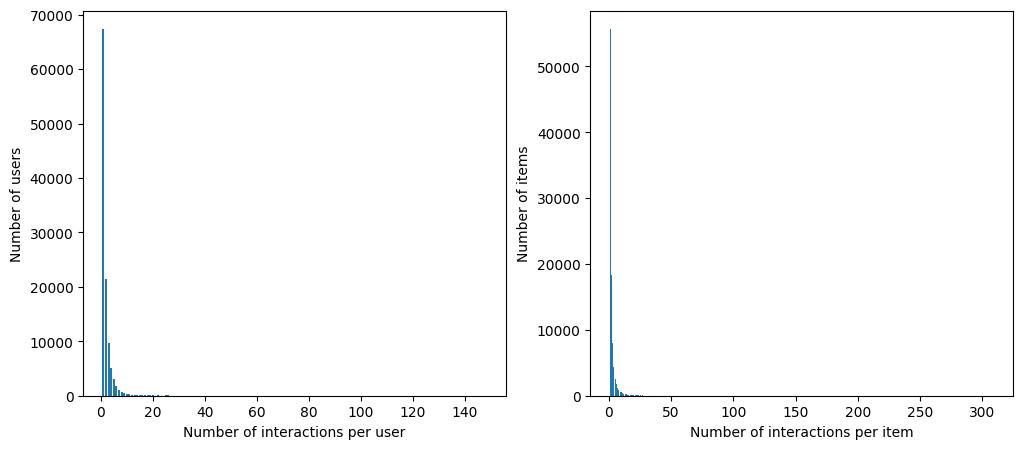

In [13]:
# plot data distribution
import matplotlib.pyplot as plt
import numpy as np
user_list = list(set([d['reviewerID'] for d in step_1_data]))
item_list = list(set([d['asin'] for d in step_1_data]))
print(f"Number of users: {len(user_list)}")
print(f"Number of items: {len(item_list)}")
user_interaction_count = {user:0 for user in user_list}
item_interaction_count = {item:0 for item in item_list}
for d in step_1_data:
    user_interaction_count[d['reviewerID']] += 1
    item_interaction_count[d['asin']] += 1
user_interaction_values = list(user_interaction_count.values())
item_interaction_values = list(item_interaction_count.values())

uni_distribution, user_counts = np.unique(user_interaction_values, return_counts=True)
ini_distribution, item_counts = np.unique(item_interaction_values, return_counts=True)
print(f"max user num_interactions: {uni_distribution[np.argmax(user_counts)]}, count: {max(user_counts)}")
print(f"max item num_interactions: {ini_distribution[np.argmax(item_counts)]}, count: {max(item_counts)}")
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.bar(uni_distribution, user_counts)
plt.xlabel('Number of interactions per user')
plt.ylabel('Number of users')
plt.subplot(1,2,2)
plt.bar(ini_distribution, item_counts)
plt.xlabel('Number of interactions per item')
plt.ylabel('Number of items')
plt.show()


=== Iteration 1 ===
Current data size: 242937
After item filtering: 109312
After item filtering: 109312
After user filtering: 36018

=== Iteration 2 ===
Current data size: 36018
After item filtering: 22886
After user filtering: 18063

=== Iteration 3 ===
Current data size: 18063
After item filtering: 15759
After user filtering: 14592

=== Iteration 4 ===
Current data size: 14592
After item filtering: 13769
After user filtering: 13318

=== Iteration 5 ===
Current data size: 13318
After item filtering: 13044
After user filtering: 12924

=== Iteration 6 ===
Current data size: 12924
After user filtering: 36018

=== Iteration 2 ===
Current data size: 36018
After item filtering: 22886
After user filtering: 18063

=== Iteration 3 ===
Current data size: 18063
After item filtering: 15759
After user filtering: 14592

=== Iteration 4 ===
Current data size: 14592
After item filtering: 13769
After user filtering: 13318

=== Iteration 5 ===
Current data size: 13318
After item filtering: 13044
After

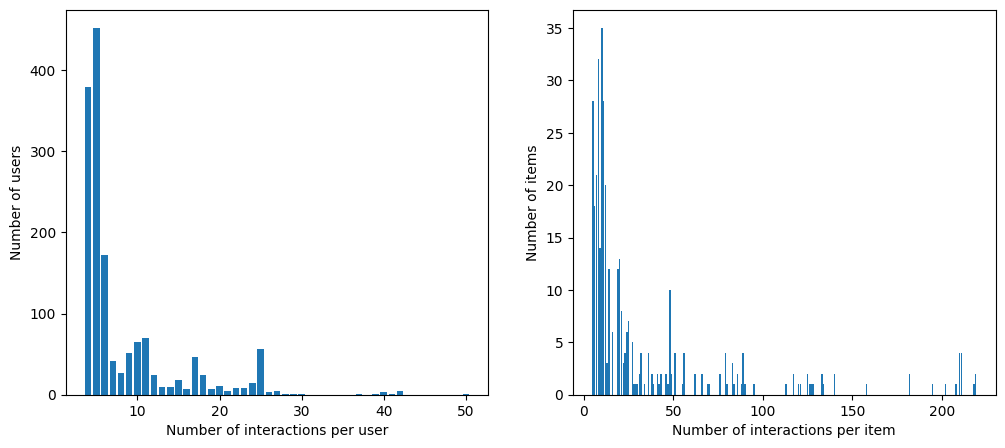

In [23]:
step_2_data = step_1_data.copy()

# 迭代过滤，直到数据稳定
MIN_USER_INTERACTIONS = 4
MIN_ITEM_INTERACTIONS = 5

prev_size = len(step_2_data)
iteration = 0
while True:
    iteration += 1
    print(f"\n=== Iteration {iteration} ===")
    print(f"Current data size: {len(step_2_data)}")
    
    # step 2.1 filter items with too few interactions
    item_list = list(set([d['asin'] for d in step_2_data]))
    item_interaction_count = {item:0 for item in item_list}
    for d in step_2_data:
        item_interaction_count[d['asin']] += 1
    
    keep_item = {
        item: item_interaction_count[item] >= MIN_ITEM_INTERACTIONS
        for item in item_list
    }
    step_2_data = [
        d for d in step_2_data
        if keep_item[d['asin']]
    ]
    print(f"After item filtering: {len(step_2_data)}")
    
    # step 2.2 filter users with too few interactions
    user_list = list(set([d['reviewerID'] for d in step_2_data]))
    user_interaction_count = {user:0 for user in user_list}
    for d in step_2_data:
        user_interaction_count[d['reviewerID']] += 1
    
    keep_user = {
        user: user_interaction_count[user] >= MIN_USER_INTERACTIONS
        for user in user_list
    }
    step_2_data = [
        d for d in step_2_data
        if keep_user[d['reviewerID']]
    ]
    print(f"After user filtering: {len(step_2_data)}")
    
    # 检查是否收敛
    if len(step_2_data) == prev_size:
        print(f"\nConverged after {iteration} iterations!")
        break
    prev_size = len(step_2_data)

# step 2.3 final statistics
user_list = list(set([d['reviewerID'] for d in step_2_data]))
item_list = list(set([d['asin'] for d in step_2_data]))
print(f"\n=== Final Statistics ===")
print(f"Number of users: {len(user_list)}")
print(f"Number of items: {len(item_list)}")
user_interaction_count = {user:0 for user in user_list}
item_interaction_count = {item:0 for item in item_list}
for d in step_2_data:
    user_interaction_count[d['reviewerID']] += 1
    item_interaction_count[d['asin']] += 1
user_interaction_values = list(user_interaction_count.values())
item_interaction_values = list(item_interaction_count.values())

uni_distribution, user_counts = np.unique(user_interaction_values, return_counts=True)
ini_distribution, item_counts = np.unique(item_interaction_values, return_counts=True)
print(f"max user num_interactions: {uni_distribution[np.argmax(user_counts)]}, count: {max(user_counts)}")
print(f"max item num_interactions: {ini_distribution[np.argmax(item_counts)]}, count: {max(item_counts)}")
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.bar(uni_distribution, user_counts)
plt.xlabel('Number of interactions per user')
plt.ylabel('Number of users')
plt.subplot(1,2,2)
plt.bar(ini_distribution, item_counts)
plt.xlabel('Number of interactions per item')
plt.ylabel('Number of items')
plt.show()


# Step 3 
save preprocessed data

In [24]:
# rename keys
processed_data = [
    {
        'user_id': d['reviewerID'],
        'item_id': d['asin'],
        'rating': d['overall'],
        'review_text': d['reviewText'],
        'review_summary': d['summary'],
        'image': d['image'].copy()
    }
    for d in step_2_data
]

In [25]:
SAVE_PATH = os.path.join(ROOT_PATH, 'data', 'preprocessed')
with open(os.path.join(SAVE_PATH, 'preprocessed_data.json'), 'w') as f:
    json.dump(processed_data, f)
with open(os.path.join(SAVE_PATH, 'user_ids.json'), 'w') as f:
    json.dump({
        idx: user_id for idx, user_id in enumerate(user_list)
    }, f)
with open(os.path.join(SAVE_PATH, 'item_ids.json'), 'w') as f:
    json.dump({
        idx: item_id for idx, item_id in enumerate(item_list)
    }, f)